In [3]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import os
import re
from matplotlib import colormaps as cmaps
from matplotlib.ticker import MultipleLocator
from ase.units import Bohr
import socket

names = {
    'nmscde008433' : r"/home/robert/Documents/Atto/Projects/HHG/Gas/H/1D/Tests/",
    'Sisyphus' : r"C:/Users/jones/Documents/Atto/Calculations/Tests/1DH/"
         }

pc = socket.gethostname()

directory = names[pc]

cm = cmaps['tab10']
intensities = ["E12", "E13", "E14", "E15"]
omega = 0.057 #This corresponds to around 800nm driving field
Dirs = ['Mask/','NoMask/'] #Whether or not I have used a mask function for computing ionisation channels
ions = 'td.general/ion_ch'
laser = 'td.general/laser'
Widths = ['Width25', 'Width50', 'Width75', 'Width100' ]
Radii = ['Rad100/', 'Rad200/', 'Rad300/', 'Rad400/', 'Rad500/' ] 


In [2]:
print(directory)

C:/Users/jones/Documents/Atto/Calculations/Tests/1DH/


Let's just begin by going over once again the defining properties of TDDFT:

So for time dependent electronic orbitals $\psi_{j}(t)$

$$i\frac{\partial}{\partial t}\psi_{j}(t) = H(t)\psi_{j}(t)$$

$$\psi_{j}(t=0) = \psi_{j}^{(0)}$$

This needs to be evaluated via the linear time evolution operator, $(T,t)$ which transforms the state vector into a solution at time T. Therefore:

$$\psi_{j}(T) = \mathcal{T}exp \Biggl\{ -i \int_{0}^{T} d\tau H(\tau)  \Biggr\} \psi_{j}^{(0)}$$

In [4]:
def dict_files_mask(radius: str = '0', file_ext: str = 'nul.txt', col: bool = False) -> dict:
    """
    This function loads the data from the files and returns it in a dictionary.

    Parameters:
    radius (str): The radius of the simulation box, specified as a string.
    file_ext (str): The extension of the file to be loaded.
    col (bool): Whether or not to extract a specific column from the multipole file.

    Returns:
    dict: A dictionary containing the data loaded from the files.

    """
    if 'multi' in file_ext:  # This is the breakdown in case I have to use the multipole file and extract things like charges from it
        # As a refresher - time in atomic units are [:, 1]; charge is [:, 2]; dipole moment in x is [:, 3]
        col = int(col)  # Therefore, in this one, the column is actually the index of the column in the multipole file
        location = directory + '/Mask/Rad' + radius + '/'

        dict = {}
        for width in Widths:
            dict[width] = {}
            for intensity in intensities:
                dict[width][intensity] = np.loadtxt(
                    location + width + '/' + intensity + '/' + file_ext
                )[:, col]  # This should be nice and simple,

    else:  # Otherwise, just load the data from the regular files
        location = directory + '/Mask/Rad' + radius + '/'

        dict = {}
        for width in Widths:
            dict[width] = {}
            for intensity in intensities:
                dict[width][intensity] = np.loadtxt(
                    location + width + '/' + intensity + '/' + file_ext
                )

    return dict

In [5]:
harm_spec = dict_files_mask('100', 'hs-mult.x')
ion_chans = dict_files_mask('100',  'td.general/ion_ch')
energies = dict_files_mask('100',  'td.general/energy')
multipoles = dict_files_mask(radius = '100', file_ext = 'td.general/multipoles', col = '3')
charges = dict_files_mask(radius = '100', file_ext = 'td.general/multipoles', col = '2')
acceleration = dict_files_mask('100', 'td.general/acceleration')

In [6]:
def plot_harm(radius = '0', plotname='Harm_Rad-'):
    """
    This function creates a plot of the harmonic spectrum as a function of the laser intensity and the radius of the simulation box.

    Parameters:
    radius (str): The radius of the simulation box, specified as a string.
    plotname (str): The name of the plot file, including the path and extension.

    Returns:
    None

    """
    # Load the data from the files
    harm_spec = dict_files_mask(radius, 'hs-mult.x')

    # Create the plot
    fig, axs = plt.subplots(ncols = 4, nrows = 4, sharex=True, sharey=False)
    fig.subplots_adjust(hspace = 0, wspace=0.175)
    fig.set_size_inches(14,4)
    fig.set_dpi(500)

    for i, width in enumerate(Widths):
        axs[i][0].set_ylim(-16.25, -3.75); axs[i][0].yaxis.set_major_locator(MultipleLocator(3))
        axs[i][1].set_ylim(-16.25, -3.75); axs[i][1].yaxis.set_major_locator(MultipleLocator(3))
        axs[i][2].set_ylim(-16.75, 2.75); axs[i][2].yaxis.set_major_locator(MultipleLocator(4))
        axs[i][3].set_ylim(-16.75, 2.75); axs[i][3].yaxis.set_major_locator(MultipleLocator(4))
        for j, ints in enumerate(intensities):
            axs[i][j].xaxis.set_minor_locator(MultipleLocator(1))
            axs[i][j].yaxis.set_minor_locator(MultipleLocator(1))
            
            axs[i][j].xaxis.set_major_locator(MultipleLocator(2))
            
            if i == 0:
                for k in range(0,26):
                    if k%2==1:
                        axs[i][j].axvspan(k-0.25, k+0.25, facecolor='grey', alpha=0.5)
            
                axs[i][j].plot(harm_spec[width][ints][:,0]/omega, 
                            np.log10(
                                harm_spec[width][ints][:,1],
                                ), 
                            color = cm(j), 
                            label = r'$I_{0} = 10^{1%s}$ W/cm$^{2}$' % (ints[-1:]))
                axs[i][j].set_xlim(0,25)
            else:
                for k in range(0,26):
                    if k%2==1:
                        axs[i][j].axvspan(k-0.25, k+0.25, facecolor='grey', alpha=0.5)
                axs[i][j].plot(harm_spec[width][ints][:,0]/omega, 
                            np.log10(
                                harm_spec[width][ints][:,1],
                                ), 
                            color = cm(j))
                axs[i][j].set_xlim(0,25)
    fig.legend(bbox_to_anchor = [0.75, 1.01], ncol = 4)
    fig.text(0.075, 0.3, 'log$_{10}$(Ints.) [a.u.]',
            rotation='vertical',
            fontsize = 14)
    
    ############################################################################################################

    fig.text(.905, 0.15, 'r$^{100}_{abs}$',
            rotation=270,
            fontsize = 14)
    
    fig.text(.905, 0.35, 'r$^{75}_{abs}$',
            rotation=270,
            fontsize = 14)
    
    fig.text(.905, 0.55, 'r$^{50}_{abs}$',
            rotation=270,
            fontsize = 14)
    
    fig.text(.905, 0.75, 'r$^{25}_{abs}$',
            rotation=270,
            fontsize = 14)
    
    ############################################################################################################
    
    fig.text(0.45, -0.025, 'Harmonic Order', fontsize = 14)
    plt.savefig(plotname+radius+'.jpg', format = 'jpg', bbox_inches='tight', pad_inches = 0, dpi = 600)
    plt.show()

In [7]:
newpath = directory + '/Mask/Rad100/Width100/E15/'

In [10]:
pot0  = np.loadtxt(newpath + 'static/v0.y=0,z=0')
plt.plot(pot0[:,0], pot0[:,1])
plt.xlabel('x [Bohr]')
plt.ylabel('V(x) [a.u.]')

Text(0, 0.5, 'V(x) [a.u.]')

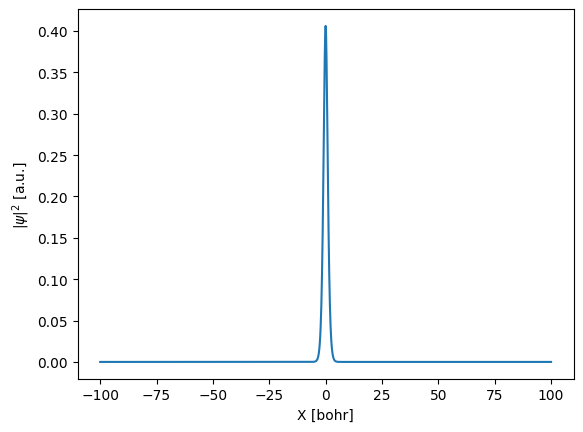

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob
newpath = directory + '/NoMask/Rad100/E15/'
pot0  = np.loadtxt(newpath + 'static/v0.y=0,z=0')


# Get a list of all the files to be plotted
file_list = [ np.loadtxt(newpath+'/output_iter/'+x+'/sqm-wf-st0001.y=0,z=0') for i,x in enumerate(os.listdir(newpath+'/output_iter/'))]

#for i in range(len(file_list)):
#    plt.plot(file_list[i][:,0], file_list[i][:,1])
#    plt.show()
# Create a figure and axis for the plot
fig, ax = plt.subplots()


# Define the update function that will be called for each frame
def update(frame):
    # Load data from the current file
    
    # Clear the axis and plot the new data
    ax.clear()
    ax.plot(file_list[frame][:, 0], file_list[frame][:, 1])
    
    # Set the title and labels
    #ax.set_title('Frame {}'.format(frame))
    ax.set_xlabel('X [bohr]')
    ax.set_ylabel(r'|$\psi$|$^{2}$ [a.u.]')
    #ax.set_ylim(-0.25, 0.25)
    
# Create the animation using the update function and the number of frames
ani = animation.FuncAnimation(fig, update, frames=len(file_list), interval=200)

# Save the animation as a gif file
ani.save(newpath+'/animation.gif', writer='pillow')



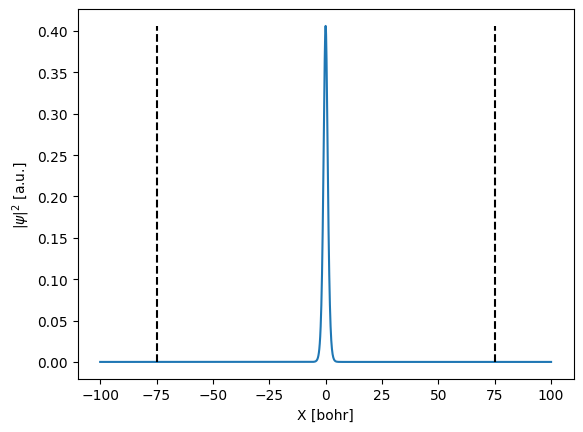

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob
newpath = directory + '/Mask/Rad100/Width75/E15/'
pot0  = np.loadtxt(newpath + 'static/v0.y=0,z=0')


# Get a list of all the files to be plotted
file_list = [ np.loadtxt(newpath+'/output_iter/'+x+'/sqm-wf-st0001.y=0,z=0') for i,x in enumerate(os.listdir(newpath+'/output_iter/'))]

#for i in range(len(file_list)):
#    plt.plot(file_list[i][:,0], file_list[i][:,1])
#    plt.show()
# Create a figure and axis for the plot
fig, ax = plt.subplots()


# Define the update function that will be called for each frame
def update(frame):
    # Load data from the current file
    
    # Clear the axis and plot the new data
    ax.clear()
    ax.plot(file_list[frame][:, 0], file_list[frame][:, 1])
    
    # Set the title and labels
    #ax.set_title('Frame {}'.format(frame))
    ax.set_xlabel('X [bohr]')
    ax.set_ylabel(r'|$\psi$|$^{2}$ [a.u.]')
    #ax.set_ylim(-0.25, 0.25)
    ax.vlines(75, min(file_list[frame][:, 1]), max(file_list[frame][:, 1]), color = 'k', linestyle = '--')
    ax.vlines(-75, min(file_list[frame][:, 1]), max(file_list[frame][:, 1]), color = 'k', linestyle = '--')
# Create the animation using the update function and the number of frames
ani = animation.FuncAnimation(fig, update, frames=len(file_list), interval=200)

# Save the animation as a gif file
ani.save(newpath+'/animation.gif', writer='pillow')



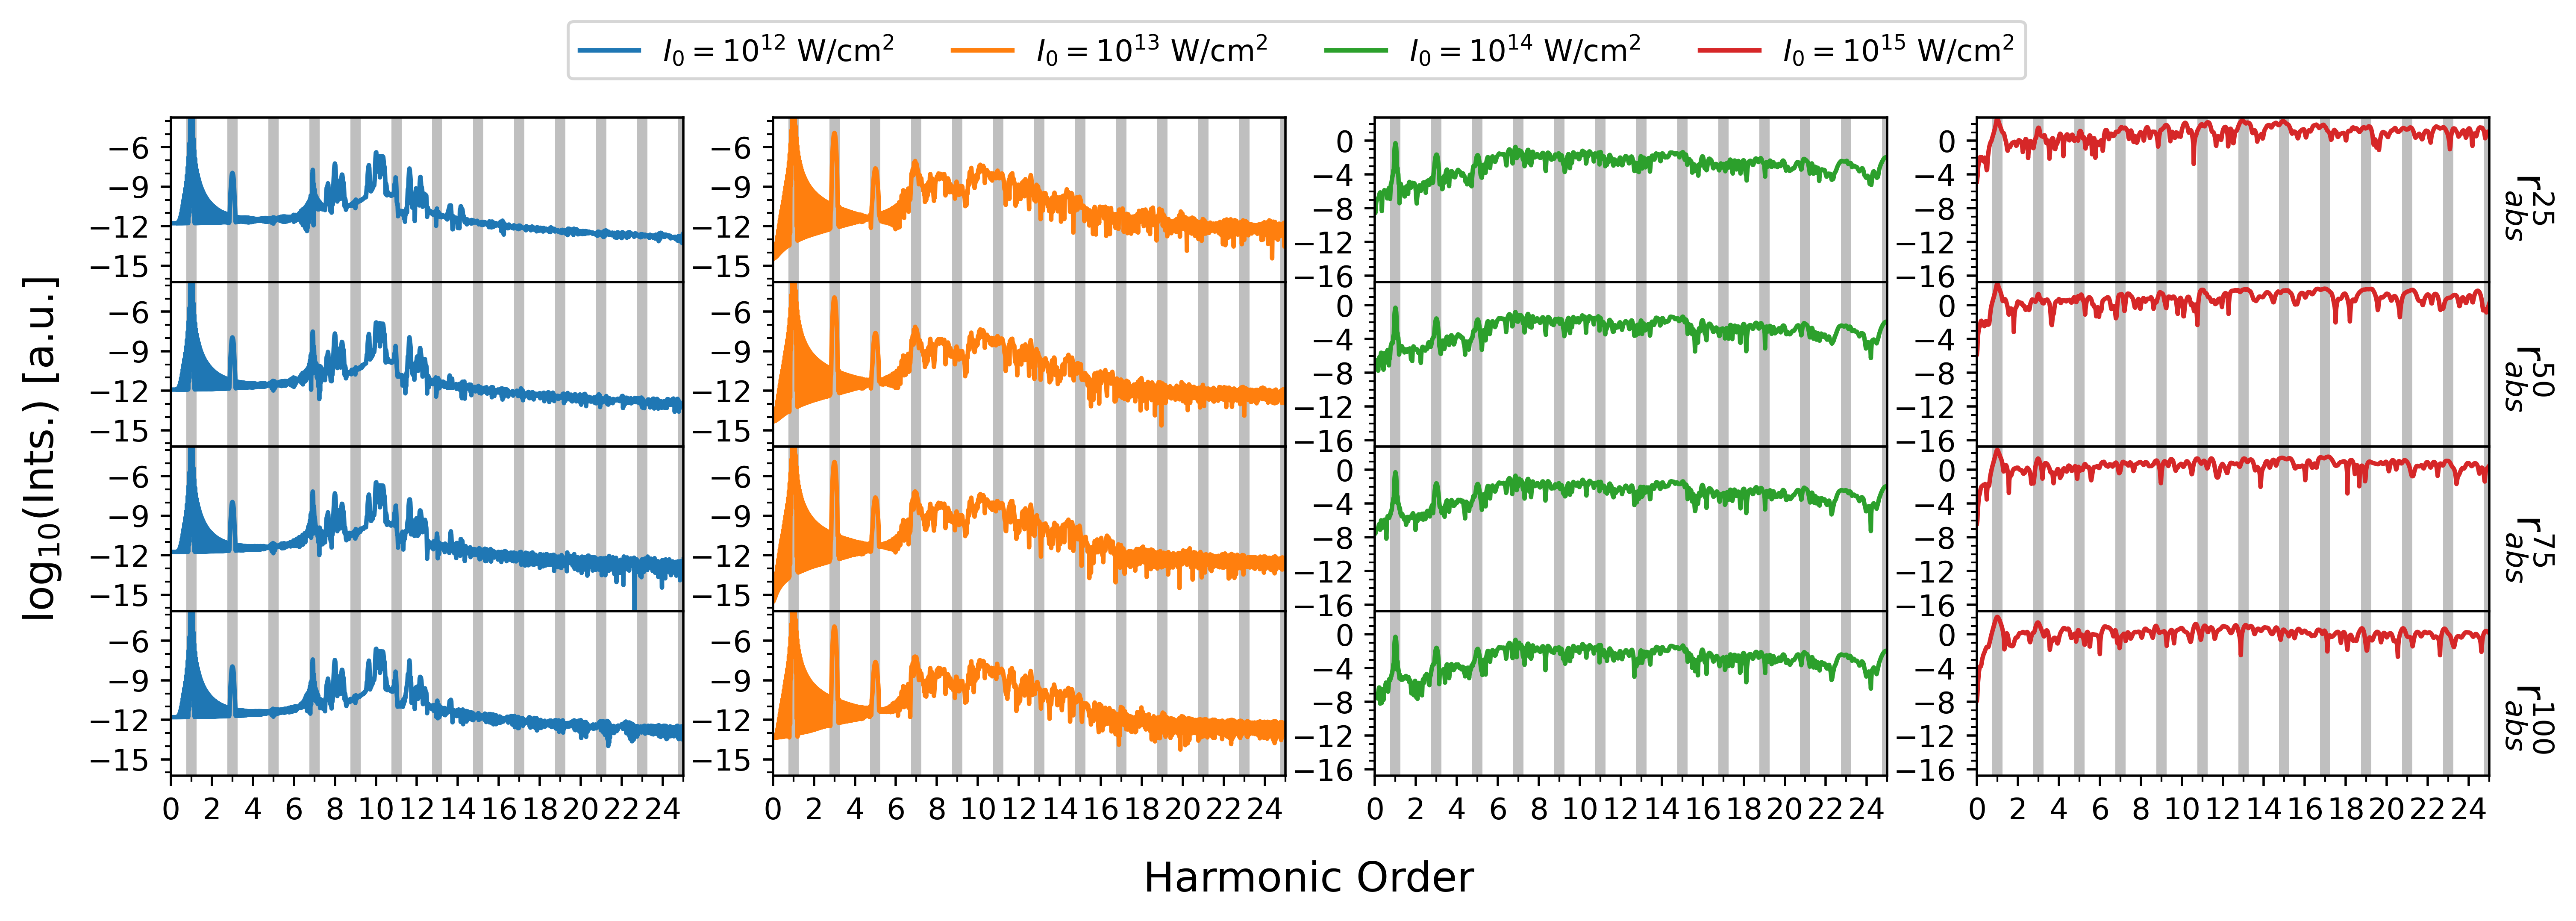

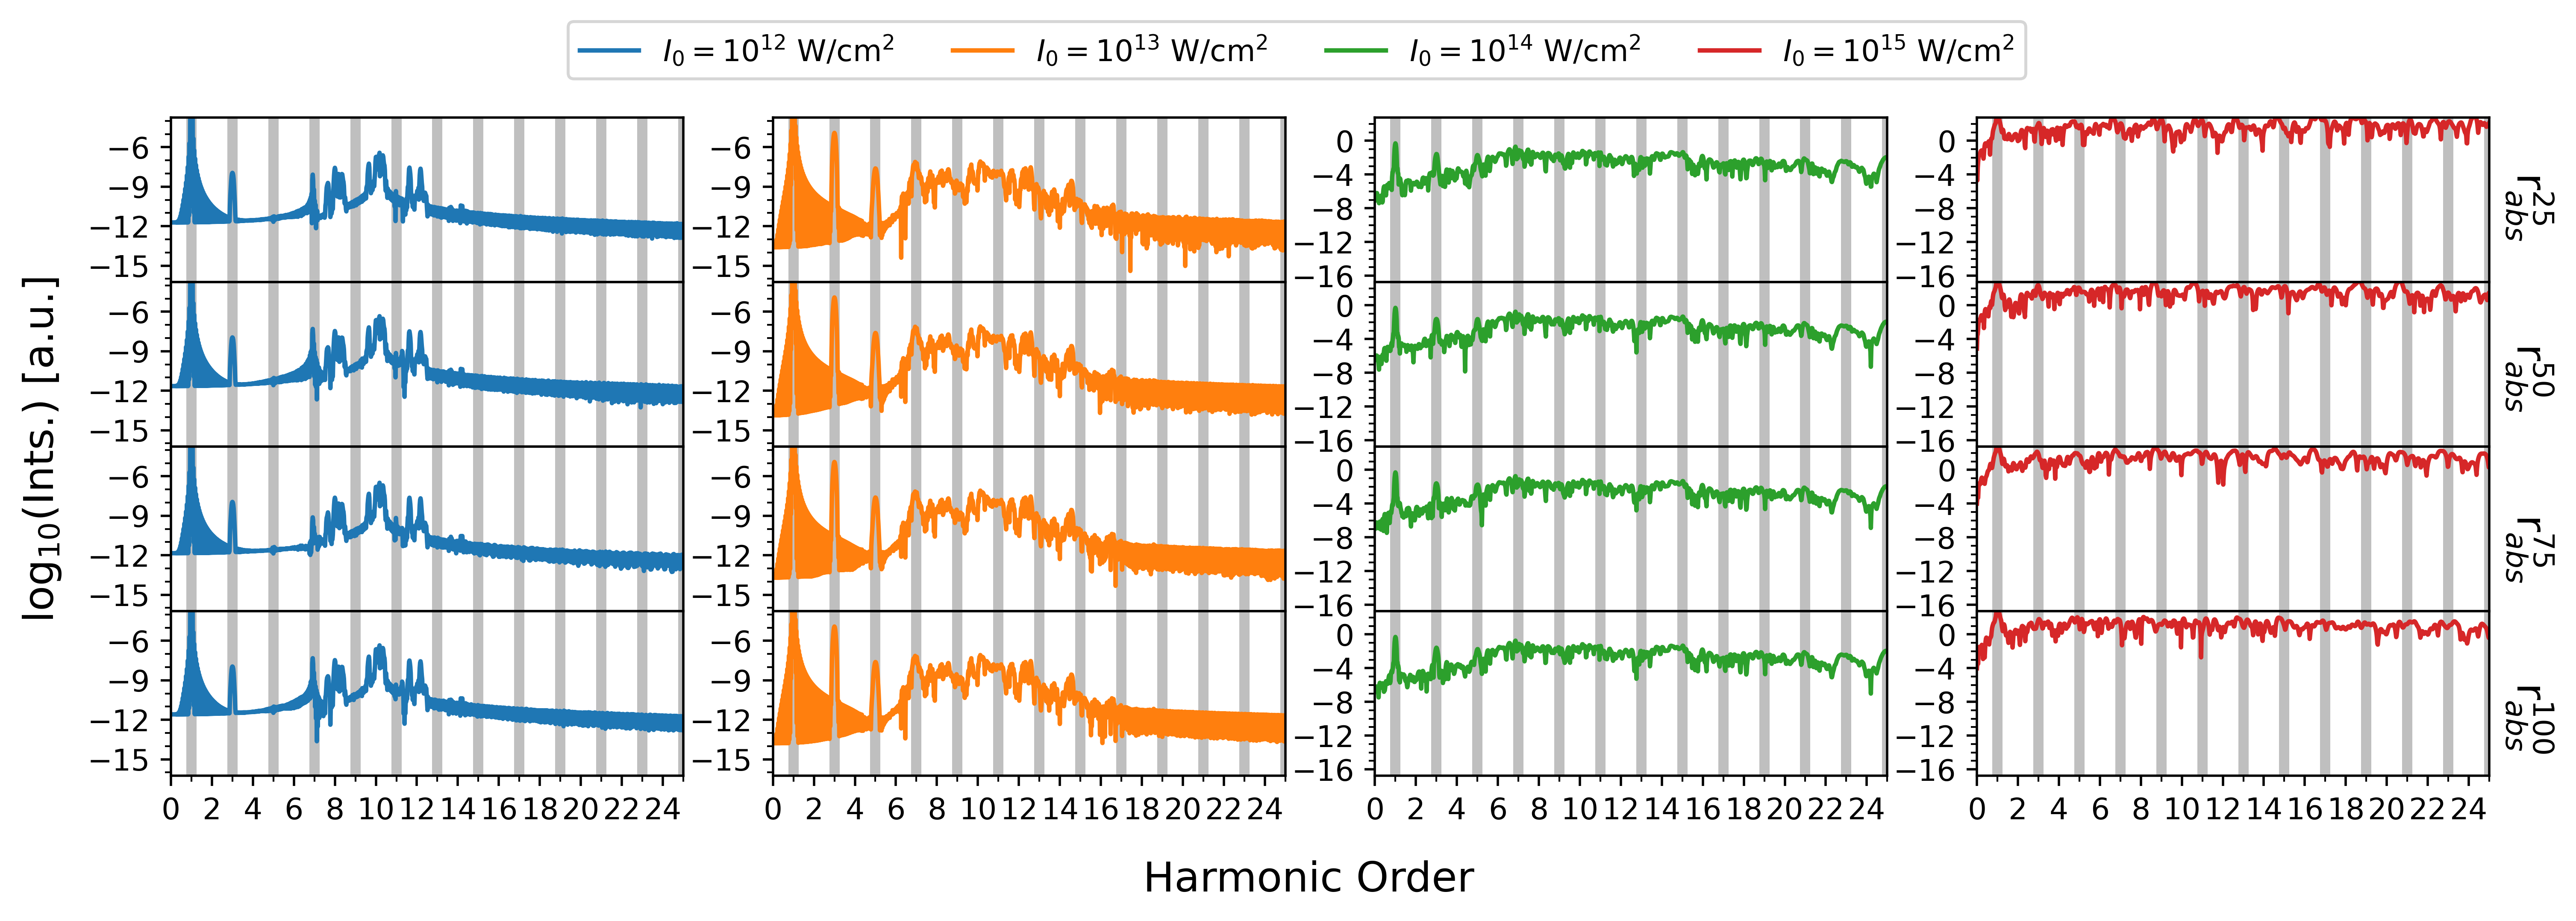

In [12]:
for R in ['100', '200', '300', '400', '500' ] :
    plot_harm(radius = R, plotname='Harm_Rad-')

In [ ]:
def dict_files_mask(radius: str = '0', file_ext: str = 'nul.txt', col: bool = False) -> dict:
    """
    This function loads the data from the files and returns it in a dictionary.

    Parameters:
    radius (str): The radius of the simulation box, specified as a string.
    file_ext (str): The extension of the file to be loaded.
    col (bool): Whether or not to extract a specific column from the multipole file.

    Returns:
    dict: A dictionary containing the data loaded from the files.

    """
    if 'multi' in file_ext:  # This is the breakdown in case I have to use the multipole file and extract things like charges from it
        # As a refresher - time in atomic units are [:, 1]; charge is [:, 2]; dipole moment in x is [:, 3]
        col = int(col)  # Therefore, in this one, the column is actually the index of the column in the multipole file
        location = directory + '/Mask/Rad' + radius + '/'

        dict = {}
        for width in Widths:
            dict[width] = {}
            for intensity in intensities:
                dict[width][intensity] = np.loadtxt(
                    location + width + '/' + intensity + '/' + file_ext
                )[:, col]  # This should be nice and simple,

    else:  # Otherwise, just load the data from the regular files
        location = directory + '/Mask/Rad' + radius + '/'

        dict = {}
        for width in Widths:
            dict[width] = {}
            for intensity in intensities:
                dict[width][intensity] = np.loadtxt(
                    location + width + '/' + intensity + '/' + file_ext
                )

    return dict

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def laser_pulse_profile(blam):
    omega = 0.057
    period = 2 * np.pi / omega
    PropagationSpectrumMaxEnergy = 100 * omega
    PropagationSpectrumEnergyStep = omega / 50
    stime = 25 * period
    dt = period / 1000
    amp = (1 * np.sqrt(10**blam) / np.sqrt(3.509470 * 10**16))
    t = np.arange(0, stime+dt, dt)
    envelope_function = amp * (np.sin(np.pi / stime * t)**2)*np.cos(omega * t)

    return t, envelope_function


In [8]:
def charge_ion_ints(Exp='12', Width = '100', Radius = '100'):
    t, laser = laser_pulse_profile(int(Exp))
    charges = dict_files_mask(radius = Radius, file_ext = 'td.general/multipoles', col = '2')
    ion_chans = dict_files_mask(Radius,  'td.general/ion_ch')    
    a = diff(sign(diff(laser))).nonzero()[0] + 1 # local min+max
    b = (diff(sign(diff(laser))) > 0).nonzero()[0] + 1 # local min
    c = (diff(sign(diff(laser))) < 0).nonzero()[0] + 1 # local max
    fig, ax1 = plt.subplots(ncols = 1, nrows=1, sharex = True, sharey = False)
    fig.subplots_adjust(hspace=0)
    # First the laser pulse profile
    fig.set_size_inches(10,3.5)
    ax1.plot(t/24.2, laser, color = [1,0.33,0.33,1], label = 'E(t)', alpha = 0.33)
    
    for k in b:
        if 10 < t[k]/24.2 < 103: 
            ax1.axvspan((t[k]/24.2)-0.4, (t[k]/24.2)+0.4, facecolor='grey', alpha=0.1)

    for k in c:
        if 10 < t[k]/24.2 < 103: 
            ax1.axvspan((t[k]/24.2)-0.4, (t[k]/24.2)+0.4, facecolor='grey', alpha=0.1)

    ax1.set_yticks([])
    ax1.set_yticklabels([])
    #ax1.set_ylabel('Amp [Ha/bohr]')
    ax2 = ax1.twinx()
    # Next, we plot the ionisation channels
    ax2.plot(t/24.1, 
             ion_chans['Width%s'%Width]['E%s'%Exp][:,2], 
             label = 'P$_{ion}$( 0.0+, t)')
    
    ax2.plot(t/24.1, 
             ion_chans['Width%s'%Width]['E%s'%Exp][:,3], 
             label = 'P$_{ion}$( 1.0+, t)')
    ax2.plot(t/24.1, 
             ion_chans['Width%s'%Width]['E%s'%Exp][:,2]+ion_chans['Width%s'%Width]['E%s'%Exp][:,3],
             label = '$\Sigma_{channels}(P_{ion})$')
    
    # Finally, this is the total charge in the system
    ax3 = ax2.twinx()
    fig.text(0.066, 0.25, 'Probability of ionisation', rotation = 90)

    ax3.plot(t/24.2, charges['Width%s'%Width]['E%s'%Exp], label = 'No. e$^{-}$', color = cm(4))
    ax3.get_yaxis().get_major_formatter().set_useOffset(False)
    ax3.set_ylabel('Q')
    ax3.set_ylim(-.05,1.35)
    ax2.set_ylim(-.05,1.35)
    fig.legend(ncol = 5, bbox_to_anchor=[0.90075, 1.0], fontsize = 11.75)
    ax1.set_xlabel('Time (fs)')
    txtrad = "Radius = %.0f $\AA$" %(float(Radius)*Bohr)
    txtwid = "Boundary = %.0f $\AA$" %(float(Width)*Bohr)
    txtexp = "I$_{0}$ = 10$^{%s}$ W / cm$^{2}$" %(int(Exp))
    
    fig.text(0.75, 0.67,
        txtrad + '\n' + txtwid + '\n' + txtexp,
        fontsize = 11
        )
    ax1.set_xlim(-2, 115)
    plt.show()

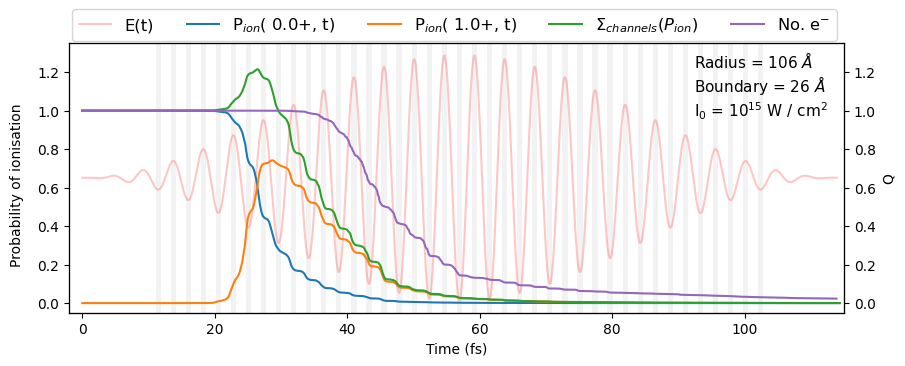

In [9]:
charge_ion_ints('15', '50', '200')

In [10]:
#for Radius in ['100', '200', '300', '400', '500']:
#    for Width in ['25', '50', '75', '100']:
#        for Exp in ['12', '13', '14', '15']:
#            charge_ion_ints(Exp, Width, Radius)

# Simulation Parameters and Results


## In this investigation, I am exploring the variation in ionisation probability and harmonic spectra as a function of the inclusion of a mask function, its size, and the box radius being used.

Below, I am using a mask for absorbing boundaries

### Box-size radius:
  - In each of these subsequent sets of calculations, the box size is fixed, and the mask function varied in radius for its cutoff. At each mask geometry, the laser profile is logarithmically varied between $10^{12}$ and $10^{15}$ $W/cm^{2}$.


## Radius = 100 bohr:

  # Mask Dimensions
  - [x] **Mask 1:**
    - Dimensions: Width 25 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 2:**
    - Dimensions: Width 50 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 3:**
    - Dimensions: Width 75 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 4:**
    - Dimensions: Width 100 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x] 
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

Radius = 200 bohr:

  ## Mask Dimensions
  - [x] **Mask 1:**
    - Dimensions: Width 25 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 2:**
    - Dimensions: Width 50 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 3:**
    - Dimensions: Width 75 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 4:**
    - Dimensions: Width 100 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x] 
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

Radius = 300 bohr:

  ## Mask Dimensions
  - [x] **Mask 1:**
    - Dimensions: Width 25 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 2:**
    - Dimensions: Width 50 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 3:**
    - Dimensions: Width 75 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x]
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

  - [x] **Mask 4:**
    - Dimensions: Width 100 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [x]
      - $I_{max} = 10^{13} W/cm^{2}$ [x] 
      - $I_{max} = 10^{14} W/cm^{2}$ [x]
      - $I_{max} = 10^{15} W/cm^{2}$ [x]

Radius = 400 bohr:

  ## Mask Dimensions
  - [x] **Mask 1:**
    - Dimensions: Width 25 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 2:**
    - Dimensions: Width 50 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 3:**
    - Dimensions: Width 75 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 4:**
    - Dimensions: Width 100 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ] 
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

Radius = 500 bohr:

  ## Mask Dimensions
  - [x] **Mask 1:**
    - Dimensions: Width 25 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 2:**
    - Dimensions: Width 50 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 3:**
    - Dimensions: Width 75 bohr
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ]
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

  - [x] **Mask 4:**
    - Dimensions: Width 100 bohr
    - Ground state calculations done. Need only apply tddft calculations.
    - Results: Going by laser intensity:
      - $I_{max} = 10^{12} W/cm^{2}$ [ ]
      - $I_{max} = 10^{13} W/cm^{2}$ [ ] 
      - $I_{max} = 10^{14} W/cm^{2}$ [ ]
      - $I_{max} = 10^{15} W/cm^{2}$ [ ]

For these subsequent calculations, no mask has been applied. But the box size radius has been varied between 100 and 500 bohr. 

## Simulation Box Size
- [ ] **Box Size 1:**
  - Dimensions: [Specify dimensions]
  - Results: [Document corresponding simulation results]

- [ ] **Box Size 2:**
  - Dimensions: [Specify dimensions]
  - Results: [Document corresponding simulation results]

- [ ] **Box Size 3:**
  - Dimensions: [Specify dimensions]
  - Results: [Document corresponding simulation results]
